# BigQuery + jupyterで機械学習を行う(BQMLの使い方について)

## これなに?

この記事はBQMLで利用できるアルゴリズム、モデルを作成する方法と、評価値の確認や特徴量生成や評価値の確認などで有用な関数についてまとめてあります  
一応続き物ということになってますが、前回記事と前々回記事はデータセットの作成までしか行っていないので、BQMLの使い方自体については、この記事だけで完結してます  
興味ある方は
- [BigQuery + jupyterで機械学習を行う(その1: データセットの作成)(前々回記事)](https://qiita.com/hiroaki_hase/items/3d7da2166b5bc495879f)
- [BigQuery + jupyterで機械学習を行う(その2: 前処理、EDA、特徴量生成)
(前回記事)](https://qiita.com/hiroaki_hase/items/5fcc9f056d44105d186e)

をお読みいただけると嬉しいです  
なお、すべての処理はjupyter上で行い、この記事自体もjupyterで書きました(jupyter上でbqを使用する方法については前々回記事参照)

In [4]:
from google.cloud.bigquery import magics
from google.oauth2 import service_account
credentials = (service_account.Credentials.from_service_account_file('/Users/hiroaki/Downloads/scalable-data-science-b045d3ddcc4c.json'))
magics.context.credentials = credentials

In [5]:
%load_ext google.cloud.bigquery

In [6]:
PROJECT ='scalable-data-science'

# BQMLの使いどころ
- 大量のデータセットから、素早く学習、予測を行いたい場合
    - アルゴリズムによりますが数千万レコードのデータセットでも数分で学習が実行できます
- 素早く機械学習システムをプロダクトに導入したい場合
    - 機械学習が実行でき、かつクエリを定期実行することも可能なので、極端に高い精度が求められなければ、低コストで機械学習システムを導入できます
- とりあえず、機械学習を試してみたい場合
    - 上記に似てますが、SQLで完結するのと、パラメータのチューニングや必要最低限の前処理などはよしなにやってくれるので、あまり機械学習に触れたことがない人でも簡単に試せます

# アルゴリズム一覧(2019/7月時点)
## 普通に使える
- linear_reg
	- 線形回帰
- logistic_reg
	- ロジスティック回帰
- kmeans
	- k-平均法
	- 唯一の教師なしアルゴリズム

## betaにだけある
- tensorflow
	- cloud storage に保存してあるmodel fileを呼び出して実行
	
## 発表だけあった
- matrix_factorization
	- 協調フィルタリング
	- 4月のNext19で発表
	- いまのところbetaにもなし

- dnn_classifier
	- いわゆるDeep Learning
	- 4月のNext19で発表
	- いまのところbetaにもなし

# 使用するデータセット

前回の記事で作成したgoogle_analyticsのdatasetから、特定の商品をclickする確率を予測します

In [77]:
%%bigquery --project $PROJECT 
SELECT * FROM `google_analytics.ga_dataset_feature` LIMIT 5

,countryHour,browserMobile,priceBin,isClick
0,{'country_hour': 'Peru_9'},{'browser_isMobile': 'Chrome_false'},bin_1,0
1,{'country_hour': 'Peru_9'},{'browser_isMobile': 'Chrome_false'},bin_1,0
2,{'country_hour': 'Peru_9'},{'browser_isMobile': 'Chrome_false'},bin_1,0
3,{'country_hour': 'Peru_9'},{'browser_isMobile': 'Chrome_false'},bin_1,0
4,{'country_hour': 'Peru_9'},{'browser_isMobile': 'Chrome_false'},bin_1,0


# 特徴量生成(`ML.BUCKETIZE`、`ML.FEATURE_CROSS`)

BQMLには、モデル作成以外にも特徴量生成のための関数も用意されてます。
- `ML.FEATURE_CROSS`
    - 交差特徴量を生成します
- `ML.BUCKETIZE`
    - 連続値を任意のしきい値で分けて、カテゴリにできます

作成した結果の特徴量は以下のようになります。具体的な使い方は[前記事](https://qiita.com/hiroaki_hase/items/5fcc9f056d44105d186e#%E3%82%88%E3%82%8A%E3%82%88%E3%81%84%E7%89%B9%E5%BE%B4%E9%87%8F%E3%82%92%E6%8E%A2%E7%B4%A2)を参考にしてください

In [76]:
%%bigquery --project $PROJECT 
SELECT 
-- 交差特徴量
    countryHour,  
-- 境界値で区切ってbin化
    priceBin
FROM `google_analytics.ga_dataset_feature` LIMIT 5

,countryHour,priceBin
0,{'country_hour': 'Peru_9'},bin_1
1,{'country_hour': 'Peru_9'},bin_1
2,{'country_hour': 'Peru_9'},bin_1
3,{'country_hour': 'Peru_9'},bin_1
4,{'country_hour': 'Peru_9'},bin_1


# モデルの構築(`CREATE MODEL`)

モデルを構築してみます。作り方は`CREATE TABLE`によく似ています  
今回は分類問題をときたいので、アルゴリズムはロジスティク回帰(`logistic_reg`)で行います  
モデルに入力する特徴量が順序特徴量として使われるか、カテゴリ特徴量として使われるかはカラムで定義されている型によって決定し、`INT64`、`FLOAT64`等の場合は数値として入力され、`STRING`、`TIMESTAMP`等の場合は、カテゴリ型として、自動でone-hot encodingされた後、モデルに入力されます

In [79]:
%%bigquery  --project $PROJECT 
CREATE OR REPLACE MODEL google_analytics.ga_model_log  
OPTIONS(
    INPUT_LABEL_COLS=['isClick'], 
    MODEL_TYPE='logistic_reg',
    -- 今回はclickしないレコード数が多い不均衡データのため、
    -- 重み値を頻度の逆数で重み付けする
    AUTO_CLASS_WEIGHTS=True,
    -- 下2つのパラメータはテスト用のデータを多くしたいがために設定。
    -- 何も指定しないと2割のデータが自動でテスト用に使用される
    DATA_SPLIT_METHOD='RANDOM',
    DATA_SPLIT_EVAL_FRACTION=0.4
    )
AS 
SELECT * FROM `google_analytics.ga_dataset_feature` 

""


`INPUT_LABEL_COLS`には正解ラベルとなるカラム名を、`MODEL_TYPE`には使用するアルゴリズムを入力します  
その他のパラメータを指定しないと、l2正則化や学習率などのハイパーパラメータや、trainデータとセットtestデータセットの分割方法などは自動で行われますが、指定したい場合はオプションで設定できます([詳細はドキュメント参照](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create?hl=ja))   

`ga_model_log`という名前でモデルが生成されました。なお、モデルを修正したり消去したいときは、table作成と同じように`REPLACE MODEL`や`DROP MODEL`で行えます

# トレーニング結果を確認(`ML.TRAINING_INFO`)
イテレーション毎に適用されたパラメータと評価値がわかります。(ただし、コンソール上から見たほうが見やすいです)

In [ ]:
%%bigquery  --project $PROJECT 
SELECT * 
FROM 
ML.TRAINING_INFO(MODEL `google_analytics.ga_model_log`)

Executing query with job ID: 8c45ee04-4a6a-41c5-bd2c-4dfbd87609ea
Query executing: 0.73s

# モデルの評価(`ML.EVALUATE`、`ML.ROC_CURVE`、`ML.CONFUSION_MATRIX`)

作成したモデルの性能を確認するための関数です。本来ならば、BQコンソール上からGUIで確認したほうがきれいに可視化されており、そちらで見たほうがわかりやすいのですが、今回jupyterで完結させるため、あえてクエリを実行して確認します

## ML.EVALUATE
基本的なモデルの性能の評価値を確認します。どのアルゴリズム(TENSORFLOWを除く)で作成したモデルでも実行可能です(ただし、評価の項目は変わります)

In [85]:
%%bigquery  --project $PROJECT 
SELECT *
FROM ML.EVALUATE(MODEL google_analytics.ga_model_log)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.03053,0.687421,0.531938,0.058464,0.690282,0.661148


## ML.ROC_CURVE
その名の通り、ROCカーブを確認できます。二値分類のロジスティック回帰のみ実行可能です。可視化を行うため、返り値を`pandas.DataFrame`で受け取ります(受け取り方は、前々記事参照)

In [81]:
%%bigquery  roc --project $PROJECT 
SELECT *
FROM ML.ROC_CURVE(MODEL `google_analytics.ga_model_log` )

In [82]:
roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.780942,0.001271,0.000000,1,0,36441,786
1,0.594805,0.035578,0.009632,28,351,36090,759
2,0.565863,0.052097,0.019703,41,718,35723,746
3,0.553026,0.062262,0.029225,49,1065,35376,738
4,0.543293,0.076239,0.039598,60,1443,34998,727


このままではよくわからないので、`matplotlib`で可視化します

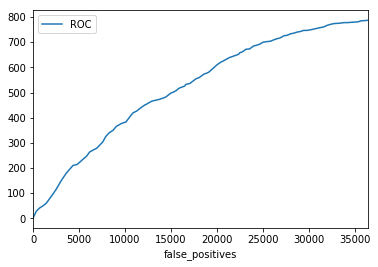

In [83]:
import matplotlib.pyplot as plt
roc.plot(x='false_positives', y='true_positives', label='ROC')
plt.show()

## ML.CONFUSION_MATRIX
その名の通り、混同行列の形で評価値を確認します。(多分類含む)ロジスティック回帰のみ実行可能です

In [84]:
%%bigquery --project $PROJECT 
SELECT *
FROM ML.CONFUSION_MATRIX(MODEL `google_analytics.ga_model_log` )

,expected_label,_0,_1
0,0,19262,17179
1,1,246,541


# 構築したモデルで予測(`ML.PREDICT`)
構築したモデルで予測を行います

In [106]:
%%bigquery  --project $PROJECT 
SELECT 
    predicted_isClick_probs,
    predicted_isClick,
    isClick
FROM ML.PREDICT(
    MODEL `google_analytics.ga_model_log`,
    -- 予測を行うためのデータセットを読み込む(今回は学習に使ったものを流用)
    (
    SELECT *
    FROM `google_analytics.ga_dataset_feature` 
    -- 適当にサンプリング
    WHERE RAND() < 0.001
    LIMIT 5
    ),
    -- positiveと判定する閾値を0.55以上とする(デフォルト0.5)
    -- 二値分類のロジスティック回帰のみ適用可能
    STRUCT(0.55 AS threshold))

,predicted_isClick_probs,predicted_isClick,isClick
0,"[{'label': 1, 'prob': 0.4583004233338707}, {'l...",0,0
1,"[{'label': 1, 'prob': 0.6149600601567031}, {'l...",1,0
2,"[{'label': 1, 'prob': 0.5112809396866935}, {'l...",0,0
3,"[{'label': 1, 'prob': 0.5038531161532933}, {'l...",0,0
4,"[{'label': 1, 'prob': 0.5093257989158967}, {'l...",0,0


`predicted_isClick_probs`の中には以下のような`STRUCT`を持った配列が入っており、それぞれのラベルを取るときの予測値が入っています  
今回は不均衡データを是正する関係で、予測値は普通の値よりも高く出ていることに注意してください
```
[{'label': 1, 'prob': 0.4582647505087995},
 {'label': 0, 'prob': 0.5417352494912004}]
```

# 使用した特徴量の確認
TODO

# モデルの重み値の確認
TODO

# まとめ
TODO 

# 参考文献

- [BQML公式ドキュメント](https://cloud.google.com/bigquery-ml/docs/reference/?hl=ja)

- [スケーラブルデータサイエンス データエンジニアのための実践Google Cloud Platform](https://www.amazon.co.jp/%E3%82%B9%E3%82%B1%E3%83%BC%E3%83%A9%E3%83%96%E3%83%AB%E3%83%87%E3%83%BC%E3%82%BF%E3%82%B5%E3%82%A4%E3%82%A8%E3%83%B3%E3%82%B9-%E3%83%87%E3%83%BC%E3%82%BF%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AE%E5%AE%9F%E8%B7%B5Google-Platform-Valliappa-Lakshmanan-ebook/dp/B07R39RLSQ/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&keywords=%E3%82%B9%E3%82%B1%E3%83%BC%E3%83%A9%E3%83%96%E3%83%AB+GCP&qid=1563756392&s=digital-text&sr=1-1)
    - bqのTech Leadである[Valliappa Lakshmanan](https://www.oreilly.com/pub/au/7304)さんの本。日本語版が最近出た
    
- [Google BigQuery: The Definitive Guide](https://www.amazon.com/Google-BigQuery-Definitive-Warehousing-Analytics/dp/1492044466)
    - 同じくValliappa Lakshmananさんの本。ただし、発売は来年

- [ビッグデータ分析・活用のためのSQLレシピ](https://www.amazon.co.jp/%E3%83%93%E3%83%83%E3%82%B0%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90%E3%83%BB%E6%B4%BB%E7%94%A8%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AESQL%E3%83%AC%E3%82%B7%E3%83%94-%E5%8A%A0%E5%B5%9C-%E9%95%B7%E9%96%80/dp/4839961263/ref=sr_1_4?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&keywords=sql&qid=1563756274&s=books&sr=1-4)
    - ここまでやるかというレベルのSQLの黒魔術がいろいろのってます